# Save and Train cropped images and masks

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pdb
import csv


from itertools import zip_longest, product, chain
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import SGD
from torch.utils.data import Dataset
from torchvision.transforms.functional import (pad, to_tensor, normalize,
                                               hflip, vflip, rotate, crop)

from PIL import Image
from IPython.display import display
from utils import plot_cells, plot_masks, plot_mask_cells, convert_cell_to_img

torch.manual_seed(0);

In [2]:
def get_jpg_files(folder):
    """폴더 내의 모든 JPG 파일의 이름을 반환합니다."""
    return {f for f in os.listdir(folder) if f.endswith('.jpg')}

def find_common_files(folder1, folder2):
    """두 폴더 내에 동일한 이름을 가진 JPG 파일의 리스트를 반환합니다."""
    files1 = get_jpg_files(folder1)
    files2 = get_jpg_files(folder2)
    common_files = files1 & files2
    return list(common_files)

# 폴더 경로를 설정합니다.
folder1 = os.path.join('data','image')
folder2 = os.path.join('data','mask')

# 동일한 이름을 가진 JPG 파일 리스트를 추출합니다.
common_jpg_files = find_common_files(folder1, folder2)

print(f"Common JPG files:{len(common_jpg_files)}")
for file in common_jpg_files[:3]:
    print(file)

Common JPG files:206
frame_0069_part_1_time_32.20.jpg
frame_0097_part_2_time_45.27.jpg
frame_0103_part_3_time_48.07.jpg


In [3]:
class CellsDataset(Dataset):
    """Constructs cell dataset"""
    def __init__(self, sample_dirs):
        super().__init__()
        self.sample_dirs = sample_dirs

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        img_fn = os.path.join('data','image',sample_dir.name)
        mask_fn = os.path.join('data','mask',sample_dir.name)

        image, mask = Image.open(img_fn).convert('RGB'), Image.open(mask_fn).convert('L')
        assert image.size == mask.size
        return image, mask, sample_dir.name

In [4]:
# Training, validation sample 분할
train_dirs = [Path(d) for d in common_jpg_files[16:]]
valid_dirs = [Path(d) for d in common_jpg_files[:16]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

img0, mask0, _ = train_cell_ds[0]
#display(img0)
train_dirs[:1], img0.size, type(mask0), valid_dirs[:1]

([WindowsPath('frame_0089_part_1_time_41.53.jpg')],
 (1080, 640),
 PIL.Image.Image,
 [WindowsPath('frame_0069_part_1_time_32.20.jpg')])

In [8]:
# Utils.py

def hflip_coordinates(start, end, image_width=256):
    """
    Apply horizontal flip to the coordinates of a line in an image.

    Parameters:
    - start: tuple, (x1, y1) coordinates of the line start point
    - end: tuple, (x2, y2) coordinates of the line end point
    - image_width: int, width of the image (default is 256)

    Returns:
    - new_start: tuple, new (x1, y1) coordinates after the horizontal flip
    - new_end: tuple, new (x2, y2) coordinates after the horizontal flip
    """
    new_x1 = image_width - 1 - start[0]
    new_y1 = start[1]
    new_x2 = image_width - 1 - end[0]
    new_y2 = end[1]

    new_start = (new_x1, new_y1)
    new_end = (new_x2, new_y2)

    return *new_start, *new_end

# 예제 사용
original_start = (102, 0)
original_end = (127, 256)

new_line = hflip_coordinates(original_start, original_end)
new_line


def vflip_coordinates(start, end, image_height=256):
    """
    Apply vertical flip to the coordinates of a line in an image and swap start and end points.

    Parameters:
    - start: tuple, (x1, y1) coordinates of the line start point
    - end: tuple, (x2, y2) coordinates of the line end point
    - image_height: int, height of the image (default is 256)

    Returns:
    - new_start: tuple, new (x1, y1) coordinates after the vertical flip
    - new_end: tuple, new (x2, y2) coordinates after the vertical flip
    """
    new_x1 = start[0]
    new_y1 = image_height - 1 - start[1]
    new_x2 = end[0]
    new_y2 = image_height - 1 - end[1]

    # Ensure coordinates are within the bounds of the image
    new_y2 = max(0, new_y2)

    # Swap the coordinates
    new_start = (new_x2, new_y2)
    new_end = (new_x1, new_y1)

    return *new_start, *new_end


def rotate_point(x, y, angle):
    angle_rad = np.radians(angle)
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    
    x_new = x * cos_theta + y * sin_theta
    y_new = -x * sin_theta + y * cos_theta
    
    return x_new, y_new

def rotate_line(r1, c1, r2, c2, angle, image_size=256):
    # Center the points around the image center
    center = image_size / 2.0
    r1_centered, c1_centered = r1 - center, c1 - center
    r2_centered, c2_centered = r2 - center, c2 - center

    # Rotate the centered points
    new_r1_centered, new_c1_centered = rotate_point(r1_centered, c1_centered, angle)
    new_r2_centered, new_c2_centered = rotate_point(r2_centered, c2_centered, angle)

    # Translate the points back to the original coordinate system
    new_r1, new_c1 = new_r1_centered + center, new_c1_centered + center
    new_r2, new_c2 = new_r2_centered + center, new_c2_centered + center

    return new_r1, new_c1, new_r2, new_c2


def show_tensor_image(tensor_image, lines=None):
    """
    Display a tensor image with optional lines.
    
    Parameters:
    - tensor_image: torch.Tensor, image tensor of shape (3, 256, 256)
    - lines: list of tuples, each containing start and end points of a line ((x1, y1), (x2, y2))
    """
    np_image = tensor_image.numpy()

    # Transpose the image to (256, 256, 3) from (3, 256, 256)
    np_image = np.transpose(np_image, (1, 2, 0))
    
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    plt.imshow(np_image)
    
    if lines is not None:
        for line in lines:
            start, end = line[:2],line[2:]
            x_values = [start[0], end[0]]
            y_values = [start[1], end[1]]
            plt.plot(x_values, y_values, 'r')  # 'r' is the color red
    
    plt.axis('off')  # Turn off axis
    plt.show()
    
    
def show_numpy_image(np_image, lines=None):
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    #plt.imshow(np_image, cmap='gray') 
    plt.imshow(np_image) 
    
    if lines is not None:
        for line in lines:
            start, end = line[:2],line[2:]
            x_values = [start[0], end[0]]
            y_values = [start[1], end[1]]
            plt.plot(x_values, y_values, 'r')  # 'r' is the color red
    
    plt.axis('off')  # Turn off axis
    plt.show()
    
    
    
######################################################################    
def is_line_in_patch(points, patch):
    rp, cp, patch_height, patch_width = patch
    patch_re = rp + patch_height
    patch_ce = cp + patch_width
    r1, c1, r2, c2 = points

    if rp <= r1 <= patch_re and cp <= c1 <= patch_ce:
        return True
    if rp <= r2 <= patch_re and cp <= c2 <= patch_ce:
        return True
    return False

def calculate_y_on_line(x1, y1, x2, y2, x):
    '''기울기 m 계산 후 x값에 대해 y계산 후 리턴'''
    if x1 == x2:
        raise ValueError("The line is vertical, y coordinate cannot be determined by x coordinate alone.")

    m = (y2 - y1) / (x2 - x1)
    y = m * (x-x1) + y1
    y_rounded = int(y + 0.5) if y - int(y) >= 0.5 else int(y)
    return y_rounded

def sort_points(r1,c1,r2,c2):
    if r1 < r2:
        return (r1, c1, r2, c2)
    else:
        return (r2, c2, r1, c1)
    
    
def crop_lines(patches, lines, im_size=(256,256)):
    new_lines = []
    for idx, (_, pat) in enumerate(patches):
        for pt in lines:
            pat = [pat[0],pat[1],im_size[0],im_size[1]] # (r,c,h,w)
            pt = [pt[1],pt[0],pt[3],pt[2]] # (r1,c1,r2,c2)
            if is_line_in_patch(pt, pat):
                pt = sort_points(*pt)
                r1,c1,r2,c2 = pt
                rs = [0,0]
                # pat[0]와 pat[0]+h로 정의되는 patch의 두 상하 경계값을 
                # 직선의 r1,r2값이 벗어나는지 체크
                rs[0] = pat[0] if r1<pat[0] else r1
                rs[1] = pat[0]+pat[2] if r2 > (pat[0]+pat[2]) else r2

                cs = [calculate_y_on_line(r1,c1,r2,c2,r) for r in rs]
                # 직선값을 (0,0)~(h,w)내로 만듬: (c1,r1,c2,r2)
                new_line = [cs[0]-pat[1],rs[0]-pat[0],cs[1]-pat[1],rs[1]-pat[0]]
                new_lines.append((idx, *new_line))
                #print(pat, pt, rs, cs, new_line)
                
    #pdb.set_trace()
    return new_lines

In [9]:
def line_endpoint(csv_fname):
    '''파일에서 line데이터 값을 읽음'''
    df = pd.read_csv(csv_fname, header=None)
    df.columns = ['type', 'x1', 'y1', 'x2', 'y2', 'filename', 'height', 'width']

    line_coordinates = {}
    for index, row in df.iterrows():
        jpg_filename = row['filename']  # 'filename' 열에서 JPG 파일명 추출
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']  
        if jpg_filename not in line_coordinates:
            line_coordinates[jpg_filename] = []
        line_coordinates[jpg_filename].append((x1, y1, x2, y2))
        
    return line_coordinates


def calcuate_bboxes(im_shape, patch_size):
    """Calculate bound boxes based on image shape and size of the bounding box
    given by `patch_size`"""
    h, w = im_shape  # 640,1080
    ph, pw = patch_size  # 256,256
    # range(0, h - ph, ph)=0부터 1080-256=824까지 256간격으로 값 생성
    steps_h = chain(range(0, h - ph, ph), [h - ph]) 
    steps_w = chain(range(0, w - pw, pw), [w - pw])

    return product(steps_h, steps_w)


class PatchedDataset(Dataset):
    """Creates patches of cells.

    Parameters
    ----------
    base_dataset: CellsDataset
        Dataset of cells
    patch_size: tuple of ints (default=(256, 256))
        The size of each patch
    random_flips: bool (default=False)
        If true, patches and masks will be randomly flipped horizontally and
        vertically.
    padding: int (default=16)
        Amount of paddding around each image and mask
    """
    def __init__(self,
                 base_dataset,
                 patch_size=(256, 256),
                 random_flips=False,
                 padding=16):
        super().__init__()
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)
        self.padding = padding
        self.random_flips = random_flips
        
        self.line_coordinates = line_endpoint(os.path.join('data','labels_line.csv'))

        coords = []
        '''
        (256x256)크기로 mask이미지를 띁어낼 좌표 계산
        0 (256, 256) [(0, (0, 0))]    [(0, (0, 0))]
        1 (256, 256) [(1, (0, 0))]    [(0, (0, 0)), (1, (0, 0))]
        3 (320, 256) [(3, (0, 0)), (3, (0, 64))]    [(0, (0, 0)), (1, (0, 0)), (2, (0, 0)), (3, (0, 0)), (3, (0, 64))]
        9 (696, 520) [(9, (0, 0)), (9, (0, 256)), (9, (0, 440)), (9, (256, 0)), (9, (256, 256)), (9, (256, 440)), ...] 
                     [(0, (0, 0)), (1, (0, 0)), (2, (0, 0)), (3, (0, 0)), (3, (0, 64)), (4, (0, 0)), ..., (9, (0, 0)), (9, (0, 256)), (9, (0, 440)), (9, (256, 0)),...]        
        '''
        for idx, (_, mask, fname) in enumerate(self.base_dataset):
            w, h = mask.size
            bboxes = calcuate_bboxes((h, w), self.patch_size)
            idx_bboxes = list(zip_longest([], bboxes, fillvalue=idx))
            #pdb.set_trace()
            new_lines = crop_lines(idx_bboxes, self.line_coordinates[fname])  ########
            idx_bboxes = [(idx, posi, []) for idx,posi in idx_bboxes]  #########
            list(map(lambda x: idx_bboxes[x[0]][2].append(x[1:]), new_lines))  #########
            coords.extend(idx_bboxes)
            #print(idx, fname, mask.size, idx_bboxes, len(coords), self.line_coordinates[fname])
        self.coords = coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        img_idx, (i, j), pts = self.coords[idx]  # idx(=4): 3,(0,64)
        cell, mask, fname = self.base_dataset[img_idx]  # (320,256),(320,256)
        h, w = self.patch_size_expanded  # (288,288),288=256+2x16
        # if idx==4:  # 4 3 0 64 (320, 256) (320, 256)
        #     print(idx, img_idx, i, j, cell.size, mask.size)
        #     pdb.set_trace()

        cell = pad(cell, self.padding, padding_mode='reflect')
        mask = pad(mask, self.padding, padding_mode='reflect')

        cell = crop(cell, i, j, h, w)
        mask = crop(mask, i, j, h, w)

        #pdb.set_trace()
        if self.random_flips:
            if random.random() < 0.5:
                cell = hflip(cell)
                mask = hflip(mask)
                pts = [hflip_coordinates(pt[:2],pt[2:]) for pt in pts]

            if random.random() < 0.5:
                cell = vflip(cell)
                mask = vflip(mask)
                pts = [vflip_coordinates(pt[:2],pt[2:]) for pt in pts]
                
            if random.random() < 0.5:
                value = random.choice([90.0, -90.0])
                cell = rotate(cell, value)
                mask = rotate(mask, value)
                pts = [rotate_line(pt[0], pt[1], pt[2], pt[3], value) for pt in pts]

        cell = to_tensor(cell)  ########## 아래: 정규화가 중요(mask를 255로 나누어 0~1로)
        mask = torch.as_tensor(np.array(mask).astype('float32')/255.0)

        # mean and std of imagenet
        cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return cell, mask, pts, fname

In [28]:
#train_ds = PatchedDataset(train_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)
val_ds = PatchedDataset(valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)

In [29]:
# def tensor_to_numpy(image):
#     np_img = image.numpy()
#     if len(np_img.shape) == 3:
#         np_img = np.transpose(np_img, (1, 2, 0))   
#     if np_img.max() == np_img.min():
#         return None
#     np_img = (np_img - np_img.min()) / (np_img.max() - np_img.min())   
#     np_img = (np_img * 255).astype(np.uint8)   
#     return Image.fromarray(np_img)

# def get_unique_filename(folder, filename):
#     base, ext = os.path.splitext(filename)
#     counter = 1
#     unique_filename = filename
#     while os.path.exists(os.path.join(folder, unique_filename)):
#         unique_filename = f"{base}_{counter}{ext}"
#         counter += 1
#     return unique_filename



# pts_all = []
# img_folder = os.path.join('crop_data', 'image')
# mask_folder = os.path.join('crop_data', 'mask')
# os.makedirs(img_folder, exist_ok=True)
# os.makedirs(mask_folder, exist_ok=True)

# padding = 16
# for idx, res in enumerate(train_ds):
#     img, mask, pts, fname = res
#     if len(pts)==0:
#         continue
        
#     unique_mask_filename = get_unique_filename(mask_folder, fname)
#     mask = tensor_to_numpy(mask[padding:-padding,padding:-padding])
#     if mask:
#         mask.save(os.path.join(mask_folder, unique_mask_filename))
#     else:
#         continue
        
#     unique_img_filename = get_unique_filename(img_folder, fname)
#     image = tensor_to_numpy(img[:,padding:-padding,padding:-padding])
#     if image:
#         image.save(os.path.join(img_folder, unique_img_filename))
    
#     pts_all.append((unique_img_filename, pts))
    
    
# for idx, res in enumerate(val_ds):
#     img, mask, pts, fname = res
#     if len(pts)==0:
#         continue
        
#     unique_mask_filename = get_unique_filename(mask_folder, fname)
#     mask = tensor_to_numpy(mask[padding:-padding,padding:-padding])
#     if mask:
#         mask.save(os.path.join(mask_folder, unique_mask_filename))
#     else:
#         continue

#     unique_img_filename = get_unique_filename(img_folder, fname)
#     image = tensor_to_numpy(img[:,padding:-padding,padding:-padding])
#     if image:
#         image.save(os.path.join(img_folder, unique_img_filename))
    
    
#     pts_all.append((unique_img_filename, pts))    

        
# with open('pts_all.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['Filename', 'Points'])  # Write header
#     for row in pts_all:
#         writer.writerow(row)

In [30]:
for idx, aa in enumerate(val_ds):  # val: 0,3,4,5,8,9 11 13 14 15 16 18 19, train: 0 3 10 13 14 15* 18* 19*  
    print(idx, aa[2], aa[3])  # aa[0]:(3,288,288), aa[1]:(288,288)
    if idx==0:
        break
        
len(val_ds), aa[2] # len(train_ds), 

0 [(0.0, 28.999999999999986, 256.0, 25.000000000000014)] frame_0069_part_1_time_32.20.jpg


(240, [(0.0, 28.999999999999986, 256.0, 25.000000000000014)])

Cropped img size: torch.Size([3, 256, 256]), Mask img size: (256, 256), 
File name: frame_0069_part_1_time_32.20.jpg


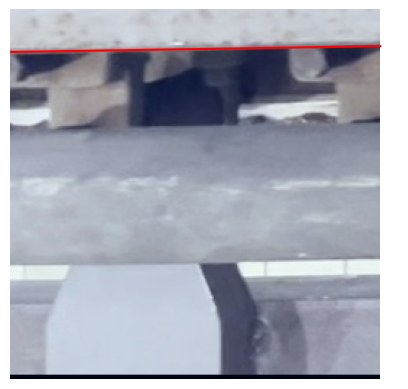

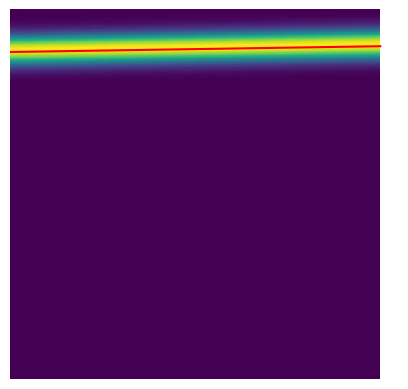

In [31]:
padding = 16
tensor_image = aa[0][:, padding:-padding, padding:-padding]
numpy_image = aa[1].numpy()[padding:-padding, padding:-padding]

print(f"Cropped img size: {tensor_image.shape}, Mask img size: {numpy_image.shape}, \nFile name: {aa[3]}")
show_tensor_image(tensor_image, aa[2])
show_numpy_image(numpy_image, aa[2])

In [36]:
from torchvision import models


def make_decoder_block(in_channels, middle_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(
            middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            encoder = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
        else:
            encoder = models.vgg16_bn(weights=None).features
        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256))

        self.dec5 = make_decoder_block(256 + 512, 512, 256)
        self.dec4 = make_decoder_block(256 + 512, 512, 256)
        self.dec3 = make_decoder_block(256 + 256, 256, 64)
        self.dec2 = make_decoder_block(64 + 128, 128, 32)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(conv5)

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        return self.final(dec1)

In [37]:
module = UNet(pretrained=True)

In [154]:
from skorch.callbacks import Freezer
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import CyclicLR

from skorch.callbacks import Checkpoint
from skorch.net import NeuralNet
from skorch.helper import predefined_split


freezer = Freezer('conv*')
cyclicLR = LRScheduler(policy=CyclicLR, 
                       base_lr=0.002, 
                       max_lr=0.2,
                       step_size_up=10, #540,
                       step_size_down=10)

class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding=(16,16)):
        super().__init__()
        self.padding = padding
        self.criterion = nn.MSELoss()

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        target = target.squeeze_(
            dim=1)[:, self.padding[0]:-self.padding[0], self.padding[1]:-self.padding[1]]
        return self.criterion(input, target)

In [155]:
net = NeuralNet(
    module,
    criterion=BCEWithLogitsLossPadding,
    criterion__padding=(16,16), #(16,20), 
    batch_size=32, #32,
    max_epochs=30,
    optimizer=SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_valid__shuffle=False,
    train_split=predefined_split(val_ds),
    callbacks=[freezer,
               cyclicLR, 
               Checkpoint(f_params='best_params.pt')],
    device='cuda',
)

In [158]:
net.fit(train_ds);

Re-initializing module.
Re-initializing criterion because the following parameters were re-set: padding.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      lr      dur
-------  ------------  ------------  ----  ------  -------
      1        0.0128        0.0127     +  0.0020  74.2212
      2        0.0082        0.0064     +  0.0218  76.3126
      3        0.0053        0.0056     +  0.0416  76.0685
      4        0.0041        0.0044     +  0.0614  75.8389
      5        0.0038        0.0041     +  0.0812  75.4722
      6        0.0035        0.0040     +  0.1010  76.7030
      7        0.0031        0.0033     +  0.1208  75.4113
      8        0.0028        0.0035        0.1406  75.3158
      9        0.0027        0.0038        0.1604  76.2183
     10        0.0157        0.0080        0.1802  76.2902
     11        0.0198        0.0193        0.2000  76.1620
     12        0.0121        0.0095        0.1802  76.7954
     13        0.0040        0.0074       

In [157]:
net.load_params(f_params='best_params_iter100.pt')
#net.load_params(f_params='best_params_0021.pt')

In [108]:
val_masks = net.predict(val_ds).squeeze(1)
val_prob_masks = 1/(1 + np.exp(-val_masks))
val_masks.shape, val_prob_masks.shape, len(val_masks)

((240, 288, 288), (240, 288, 288), 240)

In [ ]:
padding = 16
img = val_prob_masks[28][padding:-padding, padding:-padding]  # 0~1사이의 값, 배경은 0.5근방
show_numpy_image(img)
val_prob_masks.shape, img.shape

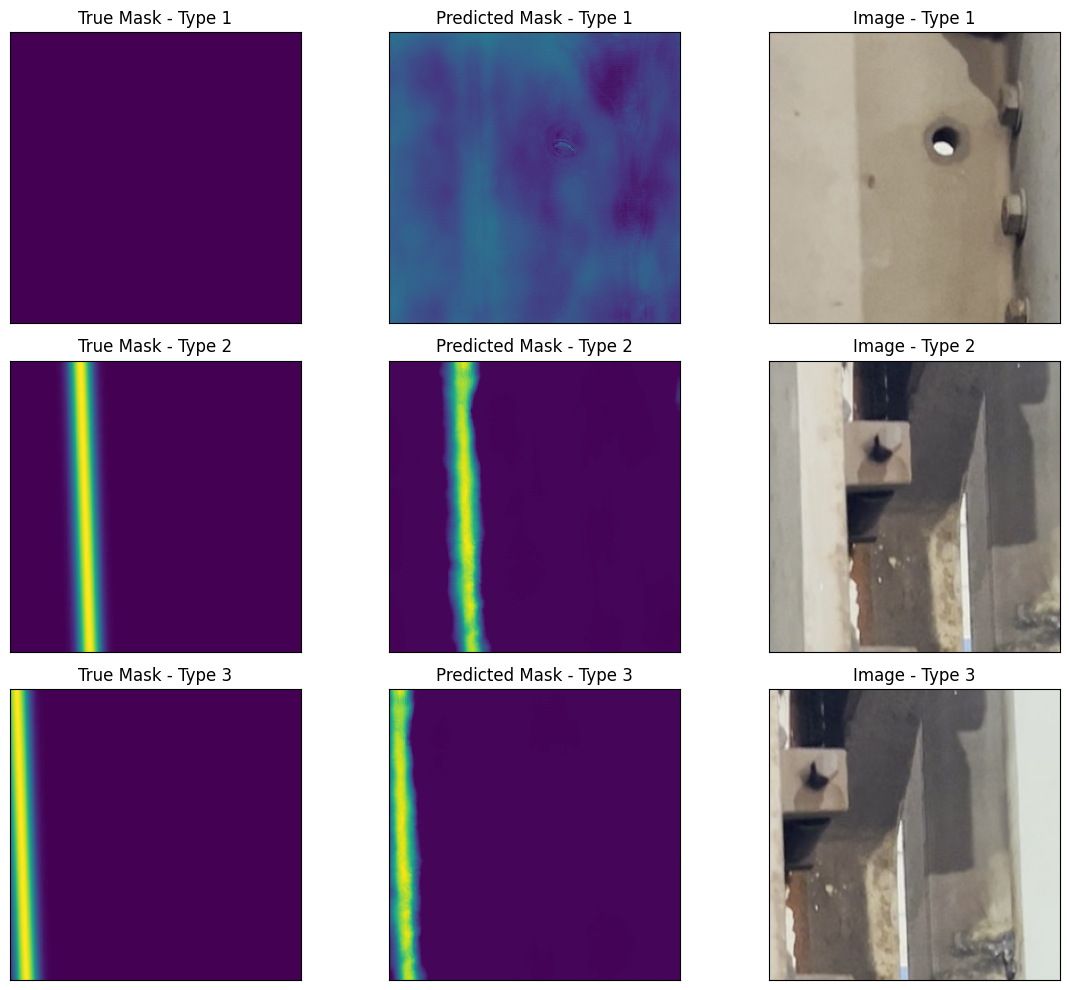

In [114]:
mask_cells = []
#for case_id in [45, 8, 81]:
#for case_id in [28, 29, 30]:
#for case_id in [37, 38, 39]:    
#for case_id in [43, 44, 45]:    
#for case_id in [46, 47, 48]:
#for case_id in [49, 50, 51]:
#for case_id in [52, 53, 54]:  # 
#for case_id in [58, 59, 60]:  #
#for case_id in [64, 65, 66]:
for case_id in [67, 68, 69]:
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

_ = plot_mask_cells(mask_cells)

In [123]:
def rotate_point(x, y, angle):
    angle_rad = np.radians(angle)
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    
    x_new = x * cos_theta + y * sin_theta
    y_new = -x * sin_theta + y * cos_theta
    
    return x_new, y_new

def rotate_line(r1, c1, r2, c2, angle, image_size=256):
    # Center the points around the image center
    center = image_size / 2.0
    r1_centered, c1_centered = r1 - center, c1 - center
    r2_centered, c2_centered = r2 - center, c2 - center

    # Rotate the centered points
    new_r1_centered, new_c1_centered = rotate_point(r1_centered, c1_centered, angle)
    new_r2_centered, new_c2_centered = rotate_point(r2_centered, c2_centered, angle)

    # Translate the points back to the original coordinate system
    new_r1, new_c1 = new_r1_centered + center, new_c1_centered + center
    new_r2, new_c2 = new_r2_centered + center, new_c2_centered + center

    return new_r1, new_c1, new_r2, new_c2

# Example usage
start_point = (0, 226)  # (r1, c1)
end_point = (256, 232)   # (r2, c2)

# Rotate by +90 degrees
angle_90 = 90
new_start_90 = rotate_line(start_point[0], start_point[1], end_point[0], end_point[1], angle_90)
print(f"Original start point: {start_point}")
print(f"Original end point: {end_point}")
print(f"Rotated +90 degrees start point: ({new_start_90[0]:.2f}, {new_start_90[1]:.2f})")
print(f"Rotated +90 degrees end point: ({new_start_90[2]:.2f}, {new_start_90[3]:.2f})")

# Rotate by -90 degrees
angle_minus_90 = -90
new_start_minus_90 = rotate_line(start_point[0], start_point[1], end_point[0], end_point[1], angle_minus_90)
print(f"Rotated -90 degrees start point: ({new_start_minus_90[0]:.2f}, {new_start_minus_90[1]:.2f})")
print(f"Rotated -90 degrees end point: ({new_start_minus_90[2]:.2f}, {new_start_minus_90[3]:.2f})")


Original start point: (0, 226)
Original end point: (256, 232)
Rotated +90 degrees start point: (226.00, 256.00)
Rotated +90 degrees end point: (232.00, 0.00)
Rotated -90 degrees start point: (30.00, 0.00)
Rotated -90 degrees end point: (24.00, 256.00)


## patch와 직선 겹침 시 직선 좌표 추출

In [512]:
def calculate_y_on_line(x1, y1, x2, y2, x):
    '''기울기 m 계산 후 x값에 대해 y계산 후 리턴'''
    if x1 == x2:
        raise ValueError("The line is vertical, y coordinate cannot be determined by x coordinate alone.")

    m = (y2 - y1) / (x2 - x1)
    y = m * (x-x1) + y1
    y_rounded = int(y + 0.5) if y - int(y) >= 0.5 else int(y)
    return y_rounded


def sort_points(r1,c1,r2,c2):
    if r1 < r2:
        return (r1, c1, r2, c2)
    else:
        return (r2, c2, r1, c1)

#### 첫개발 시뮬레이션

In [514]:
def is_line_in_patch(points, patch):
    rp, cp, patch_height, patch_width = patch
    patch_re = rp + patch_height
    patch_ce = cp + patch_width
    r1, c1, r2, c2 = points

    if rp <= r1 <= patch_re and cp <= c1 <= patch_ce:
        return True
    if rp <= r2 <= patch_re and cp <= c2 <= patch_ce:
        return True
    return False


patch = [(0,0,256,256),(0,256,256,256),(0,512,256,256),(0,768,256,256),(0,824,256,256),
         (256,0,256,256),(256,256,256,256),(256,512,256,256),(256,768,256,256),(256,824,256,256),
         (384,0,256,256),(384,256,256,256),(384,512,256,256),(384,768,256,256),(384,824,256,256)]

points = [(2, 248, 192, 247), (2, 846, 170, 852), (348,253,640,257),(330,860,640,871)]

# patch = (0, 256, 256, 256)
# points = (348, 253, 640, 257)
# is_line_in_patch(points, patch)

count = 0
for pat in patch:
    for pt in points:
        if is_line_in_patch(pt, pat):
            pt = sort_points(*pt)
            r1,c1,r2,c2 = pt
            rs[0] = pat[0] if r1<pat[0] else r1
            rs[1] = pat[0]+pat[2] if r2 > (pat[0]+pat[2]) else r2
            
            cs = [calculate_y_on_line(r1,c1,r2,c2,r) for r in rs]
            
            new_line = [rs[0]-pat[0],cs[0]-pat[1],rs[1]-pat[0],cs[1]-pat[1]]
            print(pat, pt, rs, cs, new_line)
            count = count +1
            

(0, 0, 256, 256) (2, 248, 192, 247) [2, 192] [248, 247] [2, 248, 192, 247]
(0, 768, 256, 256) (2, 846, 170, 852) [2, 170] [846, 852] [2, 78, 170, 84]
(0, 824, 256, 256) (2, 846, 170, 852) [2, 170] [846, 852] [2, 22, 170, 28]
(256, 0, 256, 256) (348, 253, 640, 257) [348, 512] [253, 255] [92, 253, 256, 255]
(256, 768, 256, 256) (330, 860, 640, 871) [330, 512] [860, 866] [74, 92, 256, 98]
(256, 824, 256, 256) (330, 860, 640, 871) [330, 512] [860, 866] [74, 36, 256, 42]
(384, 256, 256, 256) (348, 253, 640, 257) [384, 640] [253, 257] [0, -3, 256, 1]
(384, 768, 256, 256) (330, 860, 640, 871) [384, 640] [862, 871] [0, 94, 256, 103]
(384, 824, 256, 256) (330, 860, 640, 871) [384, 640] [862, 871] [0, 38, 256, 47]


#### Dataset 적용에 맞게 씨뮬레이션

In [447]:
patches = [(0, (0, 0)), (0, (0, 256)), (0, (0, 512)), (0, (0, 768)), (0, (0, 824)), 
 (0, (256, 0)), (0, (256, 256)), (0, (256, 512)), (0, (256, 768)), (0, (256, 824)), 
 (0, (384, 0)), (0, (384, 256)), (0, (384, 512)), (0, (384, 768)), (0, (384, 824))]

lines = [(248, 2, 247, 192), (846, 2, 852, 170), (253, 348, 257, 640), (860, 330, 871, 640)]


for idx, (_, pat) in enumerate(patches):
    for pt in lines:
        pat = [pat[0],pat[1],256,256]
        pt = [pt[1],pt[0],pt[3],pt[2]]
        if is_line_in_patch(pt, pat):
            pt = sort_points(*pt)
            r1,c1,r2,c2 = pt
            rs[0] = pat[0] if r1<pat[0] else r1
            rs[1] = pat[0]+pat[2] if r2 > (pat[0]+pat[2]) else r2
            
            cs = [calculate_y_on_line(r1,c1,r2,c2,r) for r in rs]
            
            new_line = [rs[0]-pat[0],cs[0]-pat[1],rs[1]-pat[0],cs[1]-pat[1]]
            print(pat, pt, rs, cs, new_line)


[0, 0, 256, 256] (2, 248, 192, 247) [2, 192] [248, 247] [2, 248, 192, 247]
[0, 768, 256, 256] (2, 846, 170, 852) [2, 170] [846, 852] [2, 78, 170, 84]
[0, 824, 256, 256] (2, 846, 170, 852) [2, 170] [846, 852] [2, 22, 170, 28]
[256, 0, 256, 256] (348, 253, 640, 257) [348, 512] [258, 260] [92, 258, 256, 260]
[256, 768, 256, 256] (330, 860, 640, 871) [330, 512] [872, 878] [74, 104, 256, 110]
[256, 824, 256, 256] (330, 860, 640, 871) [330, 512] [872, 878] [74, 48, 256, 54]
[384, 256, 256, 256] (348, 253, 640, 257) [384, 640] [258, 262] [0, 2, 256, 6]
[384, 768, 256, 256] (330, 860, 640, 871) [384, 640] [874, 883] [0, 106, 256, 115]
[384, 824, 256, 256] (330, 860, 640, 871) [384, 640] [874, 883] [0, 50, 256, 59]
